# Jane Street - WaveNet

In [1]:
import gc
import json
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_recall_curve, roc_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, PrecisionAtRecall
from tensorflow.keras.optimizers import Adam, SGD

# set tensorflow's random seed
tf.random.set_seed(13)

In [2]:
# read data as 32 bit floats
file = os.path.join(os.pardir, "input", "jane-street-market-prediction", "train.csv")
full_df = pd.read_csv(file, engine="c", dtype={c: np.float32 for c in pd.read_csv(file, nrows=1).columns})

# set missing values to -100
full_df.fillna(-100.0, inplace=True)

# split into training and validation
train_df = full_df[full_df["date"].between(0, 350)]
valid_df = full_df[full_df["date"].between(400, 500)]

In [3]:
# model training parameters
BATCH_SIZE = 4096
LEARNING_RATE = 0.001
EPOCHS = 50
SHUFFLE_BUFFER = 4 * BATCH_SIZE
LABEL_SMOOTHING = 0.01
NOISE = 0.05

# length of the time series windows
WINDOW_SIZE = 20

# autoencoder training parameters
AE_BATCH_SIZE = 4096
AE_LEARNING_RATE = 0.001
AE_EPOCHS = 1000
AE_NOISE = 0.05

# show precision at this recall in metrics
METRIC_RECALL = 0.55

# write relevant parameters to params.json for other notebooks
params = { "window_size": WINDOW_SIZE}
with open(os.path.join(os.curdir, "params.json"), "w") as file:
    json.dump(params, file)

In [5]:
# returns a processed dataset of appropriate time series windows
def dataset(df, repeat=False, shuffle=False, cache=False, prefetch=True):
    # shorthand notation for autotune option
    auto = tf.data.experimental.AUTOTUNE
    
    # translates columns names to indices
    cols = list(df.columns)
    date = cols.index("date")
    feat_start = cols.index("feature_0")
    feat_stop = 1 + cols.index("feature_129")
    resp = cols.index("resp")
    
    # select the appropriate days from df and convert to tf dataset
    ds = tf.data.Dataset.from_tensor_slices(df.values)

    # convert the data into time series windows
    ds = ds.window(WINDOW_SIZE, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(WINDOW_SIZE, drop_remainder=True))

    # filter out any time series spanning multiple dates
    def single_date(series):
        dates, ix = tf.unique(series[:, date])
        return tf.equal(tf.size(dates), tf.constant(1))

    ds = ds.filter(single_date)

    # separate the series into a training sample consisting
    # of the features and a label indicating whether the
    # response at final time is positive
    def collate(series):
        X = series[:, feat_start:feat_stop]
        y = (1.0 + tf.sign(series[-1, resp])) / 2.0
        return X, y

    ds = ds.map(collate, num_parallel_calls=auto)

    # check if the dataset should repeat once exhausted
    ds = ds.repeat() if repeat else ds
    
    # check if we should shuffle the dataset
    ds = ds.shuffle(buffer_size=SHUFFLE_BUFFER) if shuffle else ds

    # set the batch size of the dataset
    ds = ds.batch(BATCH_SIZE)
    
    # check if we should cache the dataset
    ds = ds.cache() if cache else ds

    # check if we should prefetch new batches
    ds = ds.prefetch(auto) if prefetch else ds

    return ds

In [6]:
# wave block
def Wave(inputs, filters, size, depth):
    flow = layers.Conv1D(filters=filters,
                         kernel_size=1, 
                         padding="same",
                         data_format="channels_last")(inputs)
    flow = layers.BatchNormalization()(flow)

    
    for d in range(depth):
        skip = flow
        
        tanh = layers.Conv1D(filters=filters,
                             kernel_size=size, 
                             padding="same",
                             dilation_rate=2 ** d,
                             data_format="channels_last")(flow)
        tanh = layers.Activation("tanh")(tanh)
        
        sigmoid = layers.Conv1D(filters=filters,
                                kernel_size=size, 
                                padding="same",
                                dilation_rate=2 ** d,
                                data_format="channels_last")(flow)
        sigmoid = layers.Activation("sigmoid")(sigmoid)
        
        flow = layers.Multiply()([tanh, sigmoid])    
        flow = layers.BatchNormalization()(flow)
        
        flow = layers.Conv1D(filters=filters,
                             kernel_size=1,
                             padding="same",
                             data_format="channels_last")(flow)
        
        flow = layers.Add()([skip, flow])
        flow = layers.BatchNormalization()(flow)
   
    return flow

# input & normalization
inputs = layers.Input(shape=[WINDOW_SIZE, 130])
flow = layers.BatchNormalization()(inputs)

# gaussian noise
flow = layers.GaussianNoise(stddev=NOISE)(flow)

# denoise/encode the features (includes normalization)
# this layer is trainable
#flow = layers.TimeDistributed(encoder)(inputs)

# wavenet with normalized dropouts of entire feature maps
# the first block is a bottleneck designed to strip the
# redundancy from the features
flow = Wave(flow, 64, 3, 4)
flow = layers.AlphaDropout(rate=0.1, noise_shape=[BATCH_SIZE, 1, 64])(flow)

flow = Wave(flow, 128, 3, 4)
flow = layers.AlphaDropout(rate=0.1, noise_shape=[BATCH_SIZE, 1, 128])(flow)

flow = Wave(flow, 256, 3, 4)
flow = layers.AlphaDropout(rate=0.1, noise_shape=[BATCH_SIZE, 1, 256])(flow)

# dense logic for final prediction
flow = layers.Flatten()(flow)
flow = layers.Dense(units=1)(flow)
outputs = layers.Activation("sigmoid")(flow)

# optimization parameters
loss = BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)
optimizer = Adam(learning_rate=LEARNING_RATE)
metrics = [PrecisionAtRecall(recall=METRIC_RECALL, name="p@r"), AUC(name="auc")]

# compile the model and print a summary
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 130)]    0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 20, 130)      520         input_1[0][0]                    
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 20, 130)      0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 20, 64)       8384        gaussian_noise[0][0]             
_______________________________________________________________________________________

In [7]:
# define callbacks for learning rate schedule and early stopping
stopping = EarlyStopping(monitor="val_auc",
                         mode="max",
                         patience=20,
                         min_delta=0.001,
                         restore_best_weights=True)

rate = ReduceLROnPlateau(monitor="val_loss",
                         factor=0.5,
                         patience=5,
                         min_lr=0.0005,
                         min_delta=0.001)

# get training and validation datasets and fit the model
train_ds = dataset(train_df, repeat=True, shuffle=True)
valid_ds = dataset(valid_df)
hist = model.fit(train_ds,
                 epochs=EPOCHS,
                 steps_per_epoch=len(train_df) // BATCH_SIZE,
                 validation_data=valid_ds,
                 callbacks=[rate, stopping])

Epoch 1/50
399/399 [==============================] - 423s 1s/step - loss: 0.7040 - p@r: 0.5105 - auc: 0.5064 - val_loss: 0.6961 - val_p@r: 0.4986 - val_auc: 0.5023
Epoch 2/50
399/399 [==============================] - 424s 1s/step - loss: 0.6973 - p@r: 0.5132 - auc: 0.5106 - val_loss: 0.7012 - val_p@r: 0.4990 - val_auc: 0.5043
Epoch 3/50
399/399 [==============================] - 436s 1s/step - loss: 0.6969 - p@r: 0.5144 - auc: 0.5129 - val_loss: 0.7006 - val_p@r: 0.4999 - val_auc: 0.5043
Epoch 4/50
399/399 [==============================] - 432s 1s/step - loss: 0.6957 - p@r: 0.5149 - auc: 0.5145 - val_loss: 0.6965 - val_p@r: 0.5010 - val_auc: 0.5072
Epoch 5/50
399/399 [==============================] - 435s 1s/step - loss: 0.6951 - p@r: 0.5154 - auc: 0.5158 - val_loss: 0.7021 - val_p@r: 0.4987 - val_auc: 0.5023
Epoch 6/50
399/399 [==============================] - 439s 1s/step - loss: 0.6959 - p@r: 0.5159 - auc: 0.5161 - val_loss: 0.6933 - val_p@r: 0.5023 - val_auc: 0.5077
Epoch 7/50

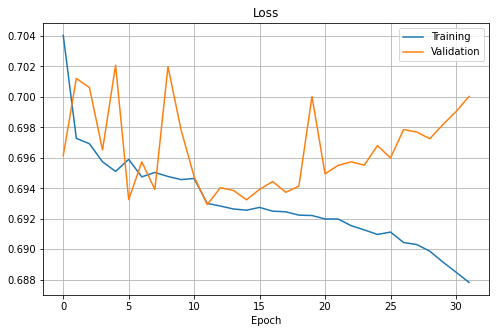

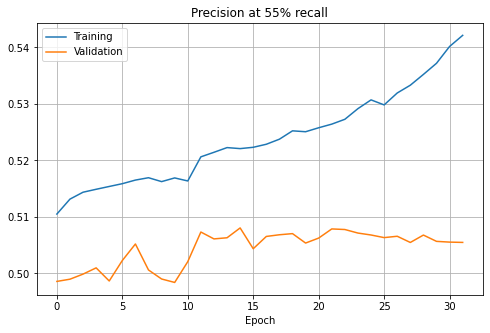

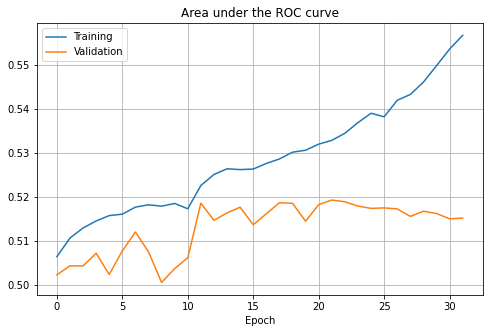

In [8]:
hist_df = pd.DataFrame(hist.history)

# loss
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["loss"], label="Training")
sns.lineplot(data=hist_df["val_loss"], label="Validation")
plt.title("Loss")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

# precision at recall
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["p@r"], label="Training")
sns.lineplot(data=hist_df["val_p@r"], label="Validation")
plt.title(f"Precision at {int(100 * METRIC_RECALL)}% recall")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

# area under ROC curve
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["auc"], label="Training")
sns.lineplot(data=hist_df["val_auc"], label="Validation")
plt.title("Area under the ROC curve")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

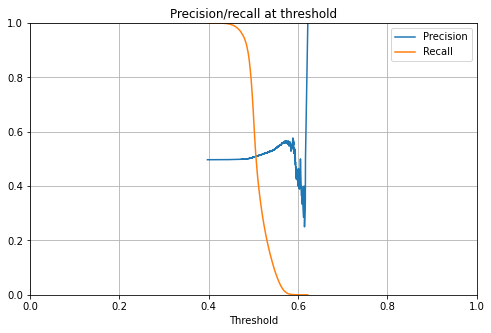

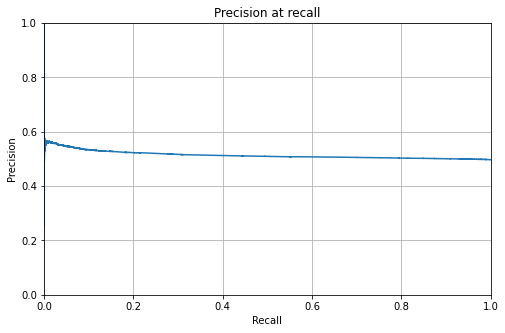

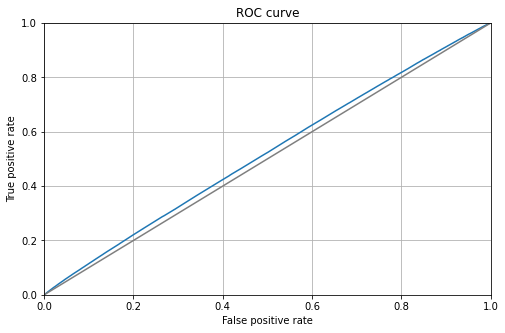

In [9]:
y_ds = valid_ds.unbatch().map(lambda X, y: y)
labels = np.vstack(list(y_ds.as_numpy_iterator()))

X_ds = valid_ds.map(lambda X, y: X)
probs = model.predict(X_ds)

# precision vs recall
precisions, recalls, thresholds = precision_recall_curve(labels, probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "tab:blue", label="Precision")
plt.plot(thresholds, recalls[:-1], "tab:orange", label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.title("Precision/recall at threshold")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, "tab:blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision at recall")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# ROC curve
false_positives, true_positives, thresholds = roc_curve(labels, probs)
plt.figure(figsize=(8, 5))
plt.plot(false_positives, true_positives, "tab:blue")
plt.plot([0, 1], [0, 1], "tab:gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

In [10]:
with open("model.json", "w") as f:
    f.write(model.to_json())

model.save_weights("model.h5")